# Flow past a 2D cylinder - noisy data

In [1]:
from os.path import join
from os import makedirs
from collections import defaultdict
from math import sqrt, log
from math import e as euler
from time import time
from itertools import product
from copy import deepcopy
import warnings
import torch as pt
import numpy as np
import matplotlib.pyplot as plt
from flowtorch.analysis import SVD, DMD, OptDMD, HOOptDMD
from notebook_utils import set_seed
from pydmd import BOPDMD

data_path = "data"
results_path = join("results", "cylinder_noise")
makedirs(results_path, exist_ok=True)
plt.rcParams["figure.dpi"] = 160
plt.rcParams["text.usetex"] = True
pt.set_default_dtype(pt.float64)
warnings.filterwarnings("ignore")


## Generation of noisy data

In [2]:
def apply_noise(dm, gamma = 0.0):
    dm_noisy = dm.clone()
    rows, cols = dm.shape
    for col in range(cols):
        dm_noisy[:, col] += (pt.rand(rows) - 0.5) * 2.0 * gamma * dm[:, col].abs()
    return dm_noisy

In [3]:
# cylinder diameter in [m]
L = 0.1
# mean inlet velocity in [m/s]
U_IN = 1.0
# single precision (32 bit) snapshots
data = pt.load(join(data_path, "cylinder.pt"))
data.keys()

dict_keys(['vorticity', 'velocity', 'x', 'y', 'volume', 't'])

In [4]:
t = data["t"].type(pt.float64)
t = t - t[0]
dt = (data["t"][1] - data["t"][0]).type(pt.float64)
dm = data["vorticity"]
dm -= dm.mean(dim=1).unsqueeze(-1)
dm_norm = (((dm - dm.min()) / (dm.max() - dm.min()) - 0.5) * 2.0).type(pt.float64)
norm = dm_norm.norm()

In [5]:
t.dtype, dt.dtype, dm_norm.dtype

(torch.float64, torch.float64, torch.float64)

In [6]:
dm.shape, t[1] - t[0], 3*L/U_IN,  (t[1] - t[0])*U_IN/L, dm.shape[1]*(t[1] - t[0])*3

(torch.Size([7190, 241]),
 tensor(0.0250),
 0.30000000000000004,
 tensor(0.2500),
 tensor(18.0751))

In [7]:
x = data["x"]
y = data["y"]

def add_contour(ax, field, vmax):
    levels = pt.linspace(-vmax, vmax, 120)
    ax.tricontourf(x, y, field, levels=levels, vmin=-vmax, vmax=vmax, cmap="seismic", extend="both")
    ax.add_patch(plt.Circle((0.2, 0.2), 0.05, color='k'))
    ax.set_aspect("equal", 'box')
    ax.set_xticklabels([])
    ax.set_yticklabels([])

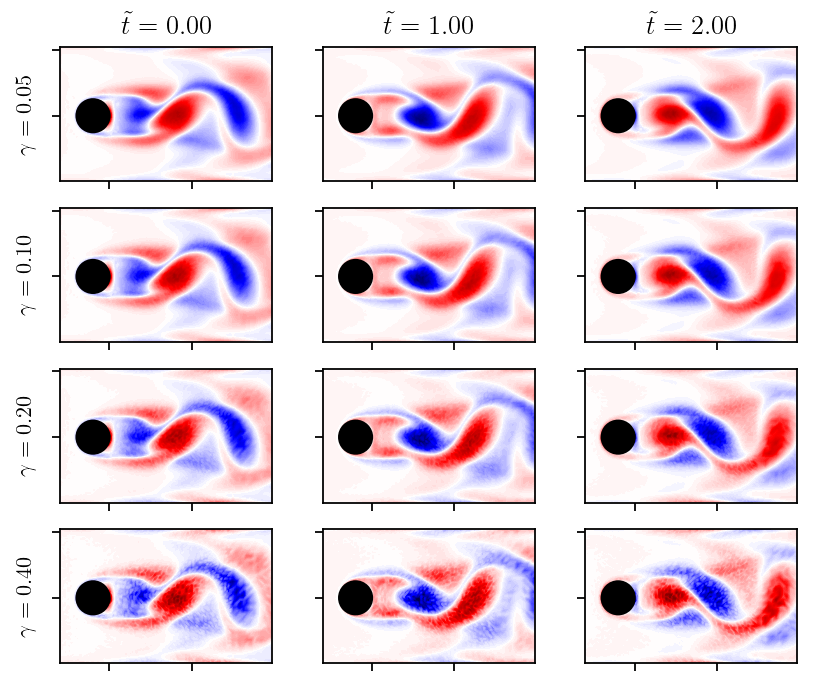

In [8]:
noise_levels_plot = (0.05, 0.1, 0.2, 0.4)
fig, axarr = plt.subplots(len(noise_levels_plot), 3, figsize=(6, 5), sharex=True, sharey=True)

for row, gamma in enumerate(noise_levels_plot):
    set_seed(row)
    dm_noisy = apply_noise(dm_norm, gamma)
    for col, i in enumerate((0, 4, 8)):
        add_contour(axarr[row, col], dm_noisy[:, i], 1.0)
        if row == 0:
            axarr[row, col].set_title(r"$\tilde{t}=" + r"{:1.2f}$".format((data["t"][i] - data["t"][0])*U_IN/L))
    axarr[row, 0].set_ylabel(r"$\gamma = {:1.2f}$".format(gamma))
plt.savefig(join(results_path, "noisy_data.png"), bbox_inches="tight")

## Taining/validation split to test for potential overfitting

In [9]:
ranks = (10, 15, 20, 25)
noise_levels = (0.4, 0.2, 0.1, 0.05)

In [9]:
opt_err, opt_pro_err = {}, {}
opt_log, opt_pro_log = {}, {}
set_seed(0)
for r in ranks:
    for g in noise_levels:
        dm_noisy = apply_noise(dm_norm, g)
        dmd = OptDMD(dm_noisy, dt, rank=r)
        dmd.train(train_size=0.9, val_size=0.1, lr=1e-4, stopping_options={"patience" : 80, "min_delta": 5e-6})
        rec = dmd.modes @ (pt.linalg.vander(dmd.eigvals, N=dm_norm.size(1)) * dmd.amplitude.unsqueeze(-1))
        opt_err[(r, g)] = (dm_norm - rec).norm() / norm
        opt_log[(r, g)] = dmd.log
        dmd = HOOptDMD(dm_noisy, dt, rank_dr=r, rank=r, delay=1)
        dmd.train(train_size=0.9, val_size=0.1, lr=1e-4, stopping_options={"patience" : 80, "min_delta": 5e-6})
        rec = dmd.modes @ (pt.linalg.vander(dmd.eigvals, N=dm_norm.size(1)) * dmd.amplitude.unsqueeze(-1))
        opt_pro_err[(r, g)] = (dm_norm - rec).norm() / norm
        opt_pro_log[(r, g)] = dmd.log

Epoch  999 - train loss: 2.408507e-02, val loss: 2.272915e-02, lr: 5.000000e-05

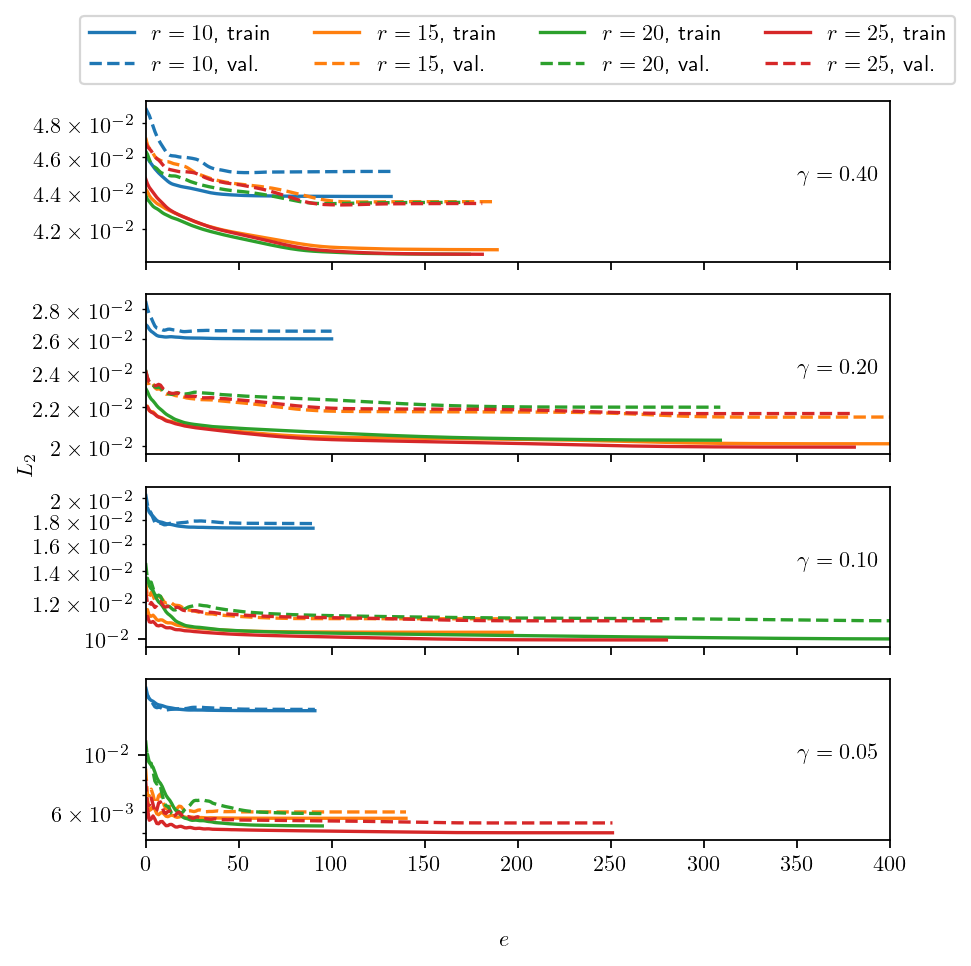

In [10]:
fig, axarr = plt.subplots(len(noise_levels), figsize=(6, 6), sharex=True, sharey=False)
for i, r in enumerate(ranks):
    for j, g in enumerate(noise_levels):
        l = opt_log[(r, g)]
        e = range(len(l["train_loss"]))
        axarr[j].plot(e, l["train_loss"], ls="-", c=f"C{i}", label=r"$r={:d}$, train".format(r))
        axarr[j].plot(e, l["val_loss"], ls="--", c=f"C{i}", label=r"$r={:d}$, val.".format(r))
        axarr[j].set_yscale("log")

for j, g in enumerate(noise_levels):
    ylim = axarr[j].get_ylim()
    axarr[j].text(350, euler**(0.5*(log(ylim[1]) + log(ylim[0]))), r"$\gamma = {:1.2f}$".format(g))
    axarr[j].set_xlim(0, 400)
axarr[0].legend(ncol=len(ranks), loc="upper center", bbox_to_anchor=(0.5, 1.6))
fig.text(0.5, 0.0, r"$e$", ha="center")
fig.text(-0.01, 0.5, r"$L_2$", va="center", rotation=90)
plt.show()

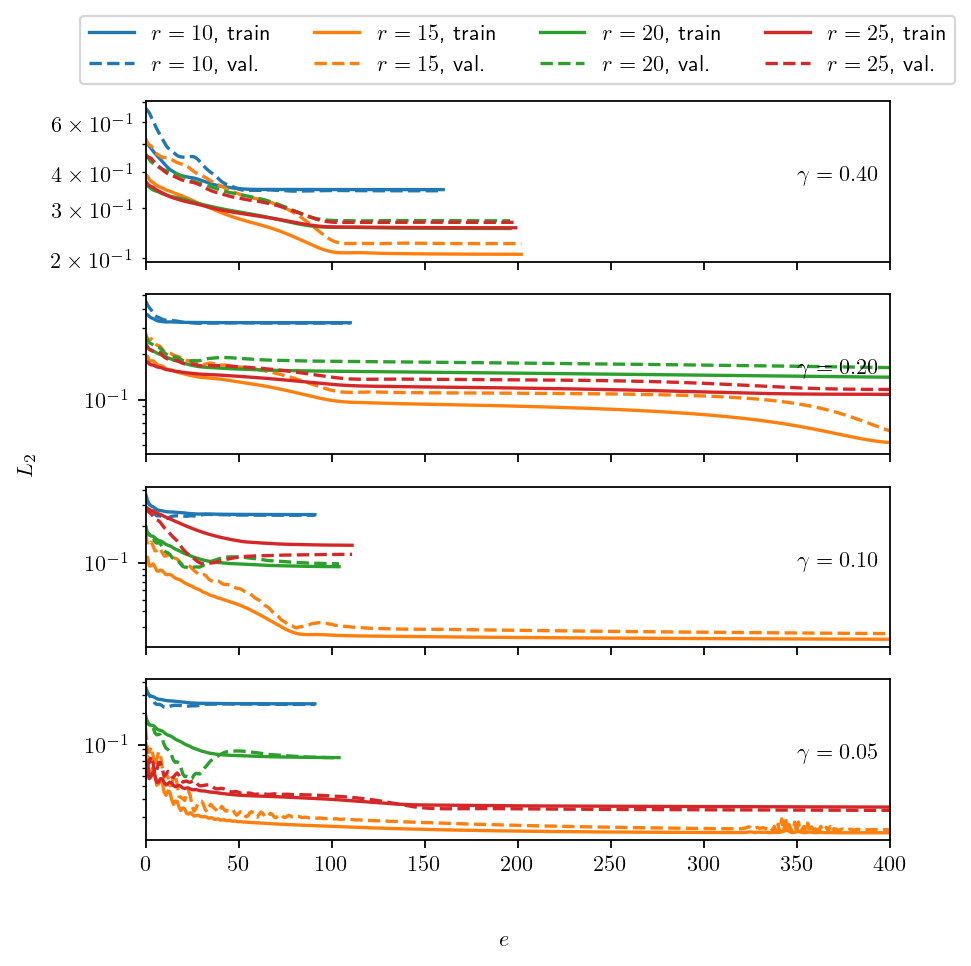

In [11]:
fig, axarr = plt.subplots(len(noise_levels), figsize=(6, 6), sharex=True, sharey=False)
for i, r in enumerate(ranks):
    for j, g in enumerate(noise_levels):
        l = opt_pro_log[(r, g)]
        e = range(len(l["train_loss"]))
        axarr[j].plot(e, l["train_loss"], ls="-", c=f"C{i}", label=r"$r={:d}$, train".format(r))
        axarr[j].plot(e, l["val_loss"], ls="--", c=f"C{i}", label=r"$r={:d}$, val.".format(r))
        axarr[j].set_yscale("log")

for j, g in enumerate(noise_levels):
    ylim = axarr[j].get_ylim()
    axarr[j].text(350, euler**(0.5*(log(ylim[1]) + log(ylim[0]))), r"$\gamma = {:1.2f}$".format(g))
    axarr[j].set_xlim(0, 400)
axarr[0].legend(ncol=len(ranks), loc="upper center", bbox_to_anchor=(0.5, 1.6))
fig.text(0.5, 0.0, r"$e$", ha="center")
fig.text(-0.01, 0.5, r"$L_2$", va="center", rotation=90)
plt.show()

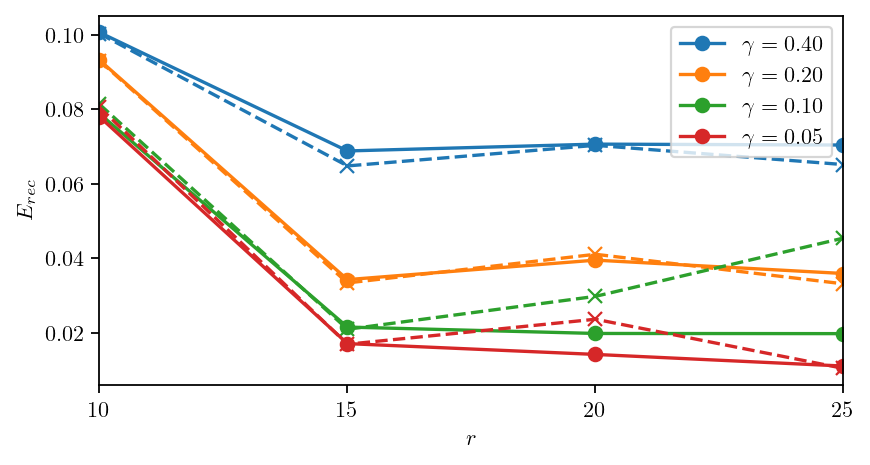

In [12]:
fig, ax = plt.subplots(figsize=(6, 3), sharex=True, sharey=True)

for j, g in enumerate(noise_levels):
    err = [opt_err[(r, g)] for r in ranks]
    ax.plot(ranks, err, ls="-", c=f"C{j}", label=r"$\gamma = {:1.2f}$".format(g), marker="o")
    err = [opt_pro_err[(r, g)] for r in ranks]
    ax.plot(ranks, err, ls="--", c=f"C{j}", marker="x")
ax.set_xticks(ranks)
ax.set_xlim(ranks[0], ranks[-1])
ax.legend()
ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$E_{rec}$")
plt.show()

## Cell for testing variable projection settings

In [13]:
for r in (10, 15, 20, 25):
    dmd_init = DMD(dm_norm, dt, rank=r, optimal=True)
    dmd = BOPDMD(svd_rank=r, num_trials=0, init_alpha=dmd_init.eigvals_cont.numpy(), eig_constraints={"conjugate_pairs"},
                 varpro_opts_dict={"verbose": False, "use_fulljac" : True})
    dmd.fit(dm_norm.numpy(), t.numpy())
    eigvals = pt.exp(pt.from_numpy(dmd.eigs)*dt)
    rec = pt.from_numpy(dmd.modes) @ (pt.linalg.vander(eigvals, N=dm_norm.size(1)) * pt.from_numpy(dmd.amplitudes).unsqueeze(-1))
    err = ((dm_norm - rec).norm() / norm).item()
    print(f"r={r}, L2={err:2.4e}")

r=10, L2=2.5620e-01
r=15, L2=1.6061e-02
r=20, L2=4.9042e-02
r=25, L2=4.8542e-02


## Comparison of exact and optimized DMD

In [15]:
def run_experiment(results, rank, gamma):
    # create test data
    dm = apply_noise(dm_norm, gamma)
    
    # exact DMD with optimal amplitudes
    start = time()
    dmd = DMD(dm, dt, rank=rank, optimal=True)
    results["time_exact"].append(time() - start)
    results["eigs_exact"].append(dmd.eigvals)
    rec = dmd.modes @ (pt.linalg.vander(dmd.eigvals, N=dm_norm.size(1)) * dmd.amplitude.unsqueeze(-1))
    results["err_exact"].append((dm_norm - rec).norm() / norm)
    
    # optimized DMD - variable projection
    start = time()
    dmd = BOPDMD(svd_rank=rank, num_trials=0, init_alpha=dmd.eigvals_cont.numpy(), eig_constraints={"conjugate_pairs"},
                 varpro_opts_dict={"verbose": False, "use_fulljac" : True})
    dmd.fit(dm.numpy(), t.numpy())
    results["time_bopt"].append(time() - start)
    eigvals = pt.exp(pt.from_numpy(dmd.eigs)*dt)
    results["eigs_bopt"].append(eigvals)
    rec = pt.from_numpy(dmd.modes) @ (pt.linalg.vander(eigvals, N=dm_norm.size(1)) * pt.from_numpy(dmd.amplitudes).unsqueeze(-1))
    results["err_bopt"].append((dm_norm - rec).norm() / norm)
    
    # optimized DMD - backprop. + gradient descent
    start = time()
    dmd = OptDMD(dm, dt, rank=rank)
    dmd.train(200, train_size=1.0, val_size=0.0, loss_key="train_loss", lr=1e-4, stopping_options={"patience" : 80, "min_delta" : 5e-6})
    results["time_opt"].append(time() - start)
    results["eigs_opt"].append(dmd.eigvals)
    rec = dmd.modes @ (pt.linalg.vander(dmd.eigvals, N=dm_norm.size(1)) * dmd.amplitude.unsqueeze(-1))
    results["err_opt"].append((dm_norm - rec).norm() / norm)
    
    # optimized DMD based on POD coefficients - backprop. + gradient descent
    start = time()
    dmd = HOOptDMD(dm, dt, rank_dr=rank, rank=rank, delay=1)
    dmd.train(400, train_size=1.0, val_size=0.0, loss_key="train_loss", lr=1e-4, stopping_options={"patience" : 80, "min_delta" : 5e-6})
    results["time_optPro"].append(time() - start)
    results["eigs_optPro"].append(dmd.eigvals)
    rec = dmd.modes @ (pt.linalg.vander(dmd.eigvals, N=dm_norm.size(1)) * dmd.amplitude.unsqueeze(-1))
    results["err_optPro"].append((dm_norm - rec).norm() / norm)

def repeat_experiment(n_trials, rank, gamma):
    results = defaultdict(list)
    for _ in range(n_trials):
        run_experiment(results, rank, gamma)
    return results

In [10]:
ranks = (10, 15, 20, 25)
noise_levels = (0.4, 0.2, 0.1, 0.05)

In [17]:
set_seed(0)
results = {}
for g in noise_levels:
    for r in ranks:
        start = time()
        results[f"{g}_{r}"] = repeat_experiment(10, r, g)
        diff = time() - start
        print(f"\nFinished parameter set gamma={g:1.2f}, r={r} in {diff:1.2f}s")
pt.save(results, join(results_path, "parameter_study.pt"))

Epoch  399 - train loss: 3.436832e-01, val loss: 0.000000e+00, lr: 1.000000e-04
Finished parameter set gamma=0.40, r=10 in 155.86s
Epoch  399 - train loss: 1.571449e-01, val loss: 0.000000e+00, lr: 1.000000e-04
Finished parameter set gamma=0.40, r=15 in 165.79s
Epoch  399 - train loss: 2.159738e-01, val loss: 0.000000e+00, lr: 1.000000e-04
Finished parameter set gamma=0.40, r=20 in 171.97s
Epoch  399 - train loss: 2.305609e-01, val loss: 0.000000e+00, lr: 1.000000e-04
Finished parameter set gamma=0.40, r=25 in 183.55s
Epoch  399 - train loss: 3.234973e-01, val loss: 0.000000e+00, lr: 1.000000e-04
Finished parameter set gamma=0.20, r=10 in 160.04s
Epoch  399 - train loss: 4.734910e-02, val loss: 0.000000e+00, lr: 1.000000e-04
Finished parameter set gamma=0.20, r=15 in 162.73s
Epoch  399 - train loss: 1.090703e-01, val loss: 0.000000e+00, lr: 1.000000e-04
Finished parameter set gamma=0.20, r=20 in 169.38s
Epoch  399 - train loss: 1.070063e-01, val loss: 0.000000e+00, lr: 1.000000e-04
Fin

In [11]:
def extract_statistics(results, gamma, ranks, key):
    mean, ci = [], []
    for r in ranks:
        data = pt.tensor(results[f"{gamma}_{r}"][key])
        mean.append(data.mean(-1))
        ci.append(1.96*data.std(-1)/sqrt(data.size(-1))) 
    return mean, ci

In [12]:
results = pt.load(join(results_path, "parameter_study.pt"))

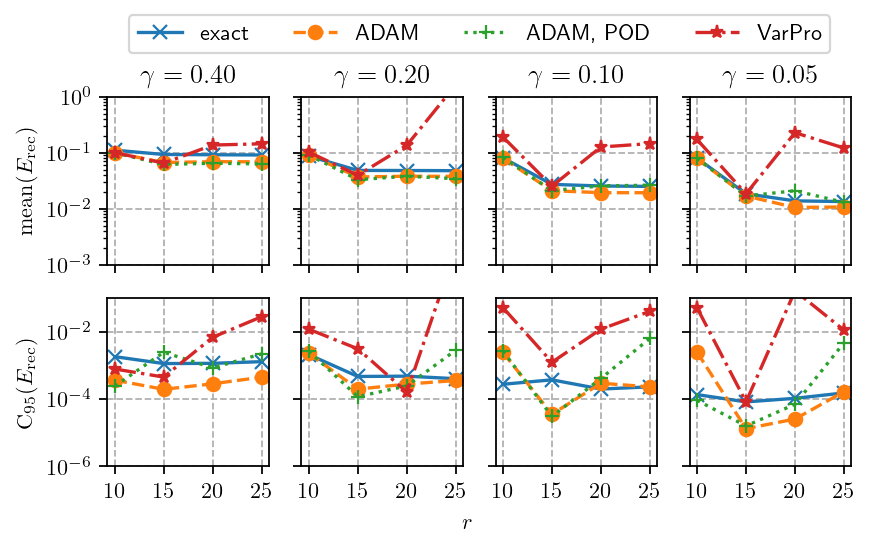

In [13]:
fig, axarr = plt.subplots(2, 4, figsize=(6, 3), sharex=True, sharey=False)

for i, g in enumerate(noise_levels):
    mean, ci = extract_statistics(results, g, ranks, "err_exact")
    axarr[0, i].plot(ranks, mean, ls="-", label="exact", marker="x")
    axarr[1, i].plot(ranks, ci, ls="-", label="exact", marker="x")
    mean, ci = extract_statistics(results, g, ranks, "err_opt")
    axarr[0, i].plot(ranks, mean, ls="--", label="ADAM", marker="o")
    axarr[1, i].plot(ranks, ci, ls="--", label="ADAM", marker="o")
    mean, ci = extract_statistics(results, g, ranks, "err_optPro")
    axarr[0, i].plot(ranks, mean, ls=":", label="ADAM, POD", marker="+")
    axarr[1, i].plot(ranks, ci, ls=":", label="ADAM, POD", marker="+")
    mean, ci = extract_statistics(results, g, ranks, "err_bopt")
    axarr[0, i].plot(ranks, mean, ls="-.", label="VarPro", marker="*")
    axarr[1, i].plot(ranks, ci, ls="-.", label="VarPro", marker="*")
    axarr[0, i].set_title(r"$\gamma = {:1.2f}$".format(g))
for ax in axarr.flatten():
    ax.set_yscale("log")
    ax.set_xticks(ranks)
    ax.grid(ls="--")
for i, ax in enumerate(axarr[0, :].flatten()):
    ax.set_ylim(1e-3, 1)
    if i > 0:
        ax.set_yticklabels([])
for i, ax in enumerate(axarr[1, :].flatten()):
    ax.set_ylim(1e-6, 1e-1)
    if i > 0:
        ax.set_yticklabels([])
axarr[0, 0].legend(ncol=4, bbox_to_anchor=(2.3, 1.55), loc="upper center")
axarr[0, 0].set_ylabel(r"$\mathrm{mean}(E_\mathrm{rec})$")
axarr[1, 0].set_ylabel(r"$\mathrm{C}_{95}(E_\mathrm{rec})$")
fig.text(0.5, -0.02, r"$r$", ha="center")
plt.savefig(join(results_path, "reconstruction_error_cylinder.pdf"), bbox_inches="tight")

In [20]:
def get_closest_ev(ev, ev_list):
    ev_split = pt.zeros((ev_list.size(0), 2))
    ev_split[:, 0], ev_split[:, 1] = ev_list.real, ev_list.imag
    ev_ref = pt.zeros(2)
    ev_ref[0], ev_ref[1] = ev.real, ev.imag
    dist = (ev_split - ev_ref).norm(dim=1)
    return ev_list[dist.argmin()]

def average_closest(ev, ev_trials):
    closest = []
    for evl in ev_trials:
        closest.append(get_closest_ev(ev, evl))
    closest = pt.tensor(closest)
    return closest.mean(), closest.std()

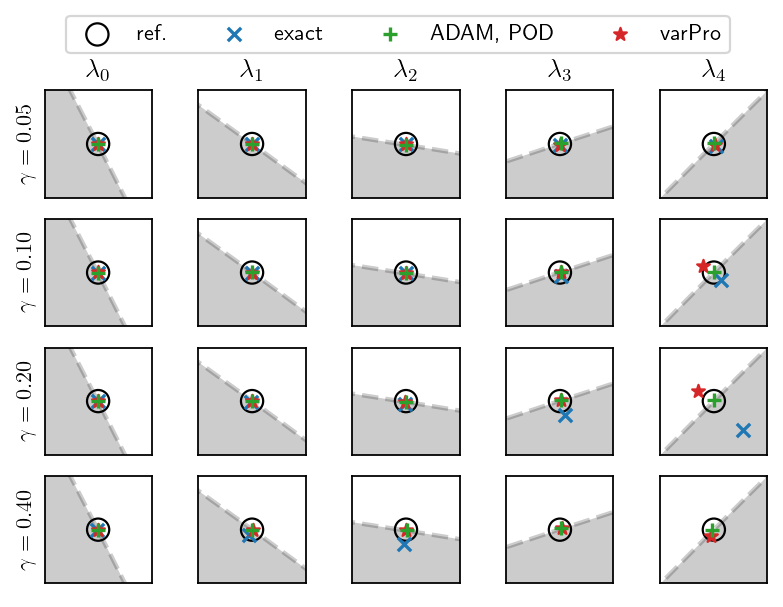

In [32]:
top_n = 5
rank = 15

fig, axarr = plt.subplots(len(noise_levels), top_n, figsize=(6, 4))

dmd_ref = DMD(dm_norm, dt, rank=rank, optimal=True)
eigs_ref = dmd_ref.eigvals[dmd_ref.top_modes(top_n, integral=True, f_min=0.01)]

box = 0.005
for i, gamma in enumerate(noise_levels[::-1]):
    for j, er in enumerate(eigs_ref):
        axarr[i, j].add_patch(plt.Circle((0.0, 0.0), radius=1.0, color="k", alpha=0.2, ec="k", lw=2, ls="--"))
        axarr[i, j].set_aspect("equal")
        ex, ex_std = average_closest(er, results[f"{gamma}_{rank}"]["eigs_exact"])
        opt, opt_std = average_closest(er, results[f"{gamma}_{rank}"]["eigs_opt"])
        optPro, optPro_std = average_closest(er, results[f"{gamma}_{rank}"]["eigs_optPro"])
        bopt, bopt_std = average_closest(er, results[f"{gamma}_{rank}"]["eigs_bopt"])
        if i == 0 and j==0:
            axarr[i, j].scatter([er.real], [er.imag], marker="o", color="k", facecolor="none", s=100, zorder=5, label="ref.")
            axarr[i, j].scatter([ex.real], [ex.imag], marker="x", color="C0", zorder=6, label="exact")
            #axarr[i, j].scatter([opt.real], [opt.imag], marker="o", color="C1", zorder=5, label="ADAM")
            axarr[i, j].scatter([optPro.real], [optPro.imag], marker="+", color="C2", zorder=10, label="ADAM, POD")
            axarr[i, j].scatter([bopt.real], [bopt.imag], marker="*", color="C3", zorder=8, label="varPro")
        else:
            axarr[i, j].scatter([er.real], [er.imag], marker="o", color="k", facecolor="none", s=100, zorder=5)
            axarr[i, j].scatter([ex.real], [ex.imag], marker="x", color="C0", zorder=6)
            #axarr[i, j].scatter([opt.real], [opt.imag], marker="o", color="C1", zorder=5)
            axarr[i, j].scatter([optPro.real], [optPro.imag], marker="+", color="C2", zorder=10)
            axarr[i, j].scatter([bopt.real], [bopt.imag], marker="*", color="C3", zorder=8)
            
        #axarr[i, j].add_patch(plt.Circle((ex.real, ex.imag), radius=2*ex_std, fc="none", ec="C0"))
        #axarr[i, j].add_patch(plt.Circle((optPro.real, optPro.imag), radius=2*optPro_std, fc="none", ec="C2"))
        #axarr[i, j].add_patch(plt.Circle((bopt.real, bopt.imag), radius=2*bopt_std, fc="none", ec="C3"))
        axarr[i, j].set_xlim(er.real-box, er.real+box)
        axarr[i, j].set_ylim(er.imag-box, er.imag+box)
        axarr[i, j].set_xticks([])
        axarr[i, j].set_yticks([])
    axarr[i, 0].set_ylabel(r"$\gamma = {:2.2f}$".format(gamma))
for i, ax in enumerate(axarr[0, :]):
    ax.set_title(r"$\lambda_{{{:d}}}$".format(i))
axarr[0, 0].legend(ncol=5, bbox_to_anchor=(3.3, 1.8), loc="upper center")
plt.savefig(join(results_path, "eigvals_15.pdf"), bbox_inches="tight")

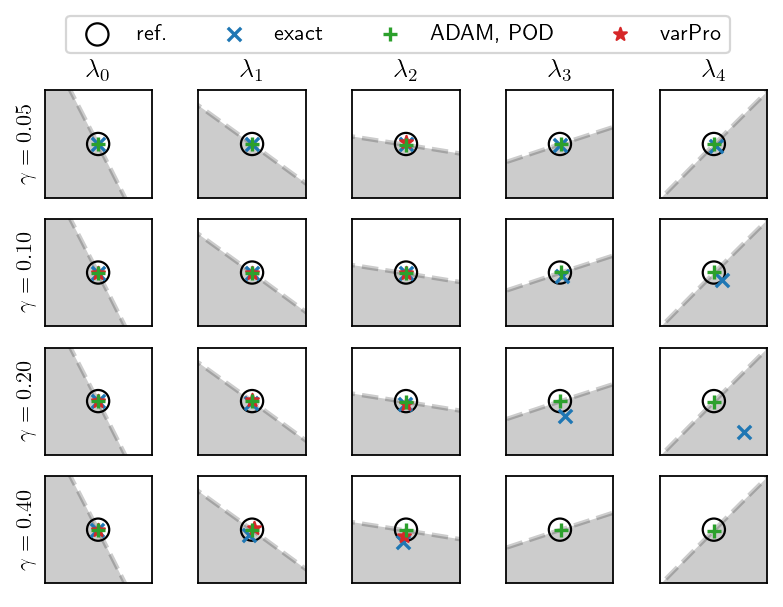

In [34]:
top_n = 5
rank = 20

fig, axarr = plt.subplots(len(noise_levels), top_n, figsize=(6, 4))

dmd_ref = DMD(dm_norm, dt, rank=rank, optimal=True)
eigs_ref = dmd_ref.eigvals[dmd_ref.top_modes(top_n, integral=True, f_min=0.01)]

box = 0.005
for i, gamma in enumerate(noise_levels[::-1]):
    for j, er in enumerate(eigs_ref):
        axarr[i, j].add_patch(plt.Circle((0.0, 0.0), radius=1.0, color="k", alpha=0.2, ec="k", lw=2, ls="--"))
        axarr[i, j].set_aspect("equal")
        ex, ex_std = average_closest(er, results[f"{gamma}_{rank}"]["eigs_exact"])
        opt, opt_std = average_closest(er, results[f"{gamma}_{rank}"]["eigs_opt"])
        optPro, optPro_std = average_closest(er, results[f"{gamma}_{rank}"]["eigs_optPro"])
        bopt, bopt_std = average_closest(er, results[f"{gamma}_{rank}"]["eigs_bopt"])
        if i == 0 and j==0:
            axarr[i, j].scatter([er.real], [er.imag], marker="o", color="k", facecolor="none", s=100, zorder=5, label="ref.")
            axarr[i, j].scatter([ex.real], [ex.imag], marker="x", color="C0", zorder=6, label="exact")
            #axarr[i, j].scatter([opt.real], [opt.imag], marker="o", color="C1", zorder=5, label="ADAM")
            axarr[i, j].scatter([optPro.real], [optPro.imag], marker="+", color="C2", zorder=10, label="ADAM, POD")
            axarr[i, j].scatter([bopt.real], [bopt.imag], marker="*", color="C3", zorder=8, label="varPro")
        else:
            axarr[i, j].scatter([er.real], [er.imag], marker="o", color="k", facecolor="none", s=100, zorder=5)
            axarr[i, j].scatter([ex.real], [ex.imag], marker="x", color="C0", zorder=6)
            #axarr[i, j].scatter([opt.real], [opt.imag], marker="o", color="C1", zorder=5)
            axarr[i, j].scatter([optPro.real], [optPro.imag], marker="+", color="C2", zorder=10)
            axarr[i, j].scatter([bopt.real], [bopt.imag], marker="*", color="C3", zorder=8)
            
        #axarr[i, j].add_patch(plt.Circle((ex.real, ex.imag), radius=2*ex_std, fc="none", ec="C0"))
        #axarr[i, j].add_patch(plt.Circle((optPro.real, optPro.imag), radius=2*optPro_std, fc="none", ec="C2"))
        #axarr[i, j].add_patch(plt.Circle((bopt.real, bopt.imag), radius=2*bopt_std, fc="none", ec="C3"))
        axarr[i, j].set_xlim(er.real-box, er.real+box)
        axarr[i, j].set_ylim(er.imag-box, er.imag+box)
        axarr[i, j].set_xticks([])
        axarr[i, j].set_yticks([])
    axarr[i, 0].set_ylabel(r"$\gamma = {:2.2f}$".format(gamma))
for i, ax in enumerate(axarr[0, :]):
    ax.set_title(r"$\lambda_{{{:d}}}$".format(i))
axarr[0, 0].legend(ncol=5, bbox_to_anchor=(3.3, 1.8), loc="upper center")
plt.savefig(join(results_path, "eigvals_20.pdf"), bbox_inches="tight")

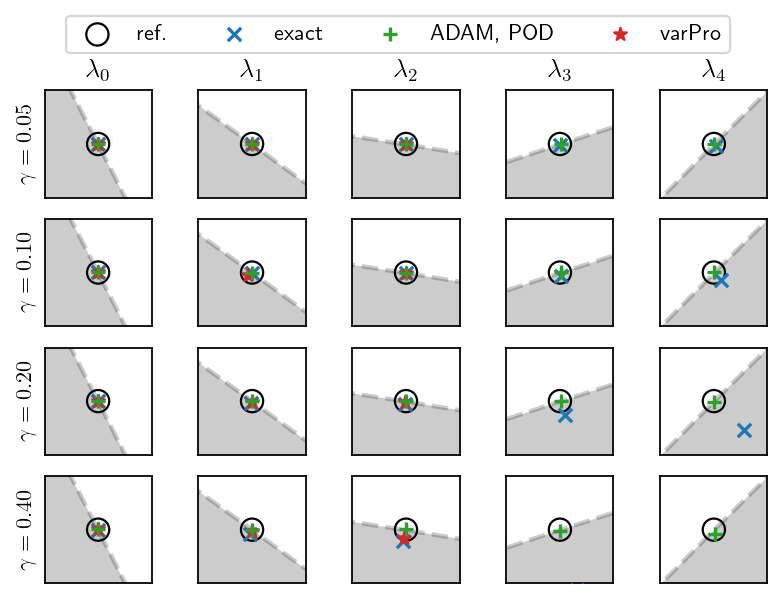

In [30]:
top_n = 5
rank = 25

fig, axarr = plt.subplots(len(noise_levels), top_n, figsize=(6, 4))

dmd_ref = DMD(dm_norm, dt, rank=rank, optimal=True)
eigs_ref = dmd_ref.eigvals[dmd_ref.top_modes(top_n, integral=True, f_min=0.01)]

box = 0.005
for i, gamma in enumerate(noise_levels[::-1]):
    for j, er in enumerate(eigs_ref):
        axarr[i, j].add_patch(plt.Circle((0.0, 0.0), radius=1.0, color="k", alpha=0.2, ec="k", lw=2, ls="--"))
        axarr[i, j].set_aspect("equal")
        ex, ex_std = average_closest(er, results[f"{gamma}_{rank}"]["eigs_exact"])
        opt, opt_std = average_closest(er, results[f"{gamma}_{rank}"]["eigs_opt"])
        optPro, optPro_std = average_closest(er, results[f"{gamma}_{rank}"]["eigs_optPro"])
        bopt, bopt_std = average_closest(er, results[f"{gamma}_{rank}"]["eigs_bopt"])
        if i == 0 and j==0:
            axarr[i, j].scatter([er.real], [er.imag], marker="o", color="k", facecolor="none", s=100, zorder=5, label="ref.")
            axarr[i, j].scatter([ex.real], [ex.imag], marker="x", color="C0", zorder=6, label="exact")
            #axarr[i, j].scatter([opt.real], [opt.imag], marker="o", color="C1", zorder=5, label="ADAM")
            axarr[i, j].scatter([optPro.real], [optPro.imag], marker="+", color="C2", zorder=10, label="ADAM, POD")
            axarr[i, j].scatter([bopt.real], [bopt.imag], marker="*", color="C3", zorder=8, label="varPro")
        else:
            axarr[i, j].scatter([er.real], [er.imag], marker="o", color="k", facecolor="none", s=100, zorder=5)
            axarr[i, j].scatter([ex.real], [ex.imag], marker="x", color="C0", zorder=6)
            #axarr[i, j].scatter([opt.real], [opt.imag], marker="o", color="C1", zorder=5)
            axarr[i, j].scatter([optPro.real], [optPro.imag], marker="+", color="C2", zorder=10)
            axarr[i, j].scatter([bopt.real], [bopt.imag], marker="*", color="C3", zorder=8)
            
        #axarr[i, j].add_patch(plt.Circle((ex.real, ex.imag), radius=2*ex_std, fc="none", ec="C0"))
        #axarr[i, j].add_patch(plt.Circle((optPro.real, optPro.imag), radius=2*optPro_std, fc="none", ec="C2"))
        #axarr[i, j].add_patch(plt.Circle((bopt.real, bopt.imag), radius=2*bopt_std, fc="none", ec="C3"))
        axarr[i, j].set_xlim(er.real-box, er.real+box)
        axarr[i, j].set_ylim(er.imag-box, er.imag+box)
        axarr[i, j].set_xticks([])
        axarr[i, j].set_yticks([])
    axarr[i, 0].set_ylabel(r"$\gamma = {:2.2f}$".format(gamma))
for i, ax in enumerate(axarr[0, :]):
    ax.set_title(r"$\lambda_{{{:d}}}$".format(i))
axarr[0, 0].legend(ncol=5, bbox_to_anchor=(3.3, 1.8), loc="upper center")
plt.savefig(join(results_path, "eigvals_25.pdf"), bbox_inches="tight")